# Analysis to pick the best token length for ECOLI cohort

## Read bed files containing tokens

In [1]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'ECOLI')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,1,3,GAA,0.024555,AH21B049
1,1,4,12,AAACCCCGG,0.019281,AH21B049
2,1,13,17,TCAAT,0.042749,AH21B049
3,1,18,22,AAGGC,0.058446,AH21B049
4,1,23,27,CGGGG,-0.002272,AH21B049
...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077
247349729,5,259939,259942,GGCC,0.024973,ALF22C077


## Calculate token lengths

In [2]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,1,3,GAA,0.024555,AH21B049,3
1,1,4,12,AAACCCCGG,0.019281,AH21B049,9
2,1,13,17,TCAAT,0.042749,AH21B049,5
3,1,18,22,AAGGC,0.058446,AH21B049,5
4,1,23,27,CGGGG,-0.002272,AH21B049,5
...,...,...,...,...,...,...,...
247349726,5,259913,259920,GCTACCCG,0.012245,ALF22C077,8
247349727,5,259921,259928,TTGGTGTG,0.000125,ALF22C077,8
247349728,5,259929,259938,CCTGTTCCGT,-0.000540,ALF22C077,10
247349729,5,259939,259942,GGCC,0.024973,ALF22C077,4


## Calculate token lengt counts

In [4]:
bedDf['token_length'].value_counts()

token_length
6     60552510
7     45341597
8     34858185
9     33305012
5     25414480
10    17681732
4     13288147
3      8283051
11     5591565
2      1751088
12      718286
1       322207
16      158325
13       57568
15       15386
14       10592
Name: count, dtype: int64

## Visualise token lengths

<Axes: >

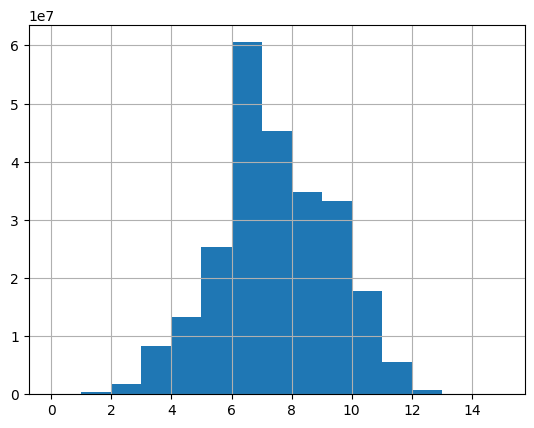

In [33]:
bedDf['token_length'].hist(bins=list(range(16)))

## Generate with and without signature files for different token lengths

In [ ]:
import os

from pathlib import Path


for tokenLength in range(5, 15):
    print('tokenLength: ', tokenLength)
    tokensDf = bedDf[bedDf.token_length > tokenLength]
    highscoreTokens = list(tokensDf.sort_values(by=['score'], ascending=False).tokens.unique()[:10])
    groupedDf = tokensDf[tokensDf.tokens.isin(highscoreTokens)].groupby(by=['tube_id'])['tokens'].nunique().reset_index().rename(columns={'tokens': 'unique_token_count'})
    uniqueTokenCountCountsDf = groupedDf.unique_token_count.value_counts().reset_index().sort_values(by=['unique_token_count'], ascending=False)
    uniqueTokenCountCountsDf['cumulative_count'] = uniqueTokenCountCountsDf['count'].cumsum()
    uniqueTokenCountCountsDf['cumulative_proportion'] = uniqueTokenCountCountsDf['cumulative_count']/uniqueTokenCountCountsDf['count'].sum()
    uniqueTokenCountCountsDf = uniqueTokenCountCountsDf.sort_values(by=['cumulative_proportion'])
    print('uniqueTokenCountCountsDf: ', uniqueTokenCountCountsDf)
    countCutoff = int(uniqueTokenCountCountsDf[(uniqueTokenCountCountsDf.cumulative_proportion > 0.2)][:1].unique_token_count.values[0])
    print('countCutoff: ', countCutoff)
    withoutSignatureDf = groupedDf[groupedDf.unique_token_count < countCutoff]
    print('without signature: ', withoutSignatureDf.shape[0])
    withSignatureDf = groupedDf[groupedDf.unique_token_count >= countCutoff]
    print('with signature: ', withSignatureDf.shape[0])
    withoutSignatureDf.tube_id.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_' + str(tokenLength) + '_wos_tubeids.txt'), index=False)
    withSignatureDf.tube_id.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_' + str(tokenLength) + '_ws_tubeids.txt'), index=False)

tokenLength:  5
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    769               769               0.893148
1                   9     89               858               0.996516
2                   8      3               861               1.000000
countCutoff:  10
without signature:  92
with signature:  769
tokenLength:  6
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    769               769               0.893148
1                   9     89               858               0.996516
2                   8      3               861               1.000000
countCutoff:  10
without signature:  92
with signature:  769
tokenLength:  7
uniqueTokenCountCountsDf:     unique_token_count  count  cumulative_count  cumulative_proportion
0                  10    612               612               0.710801
1                   9    197               809   

IndexError: index 0 is out of bounds for axis 0 with size 0

## Run log rank test

In [54]:
import os

from pathlib import Path

import pandas as pd

from lifelines.utils import datetimes_to_durations

from lifelines.statistics import logrank_test


rows = []


journeysDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'data', 'full_cohort', 'journry_times.csv'))
mappingDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'patient_tube_id_mapping_full.tsv'), sep='\t')[['tube_code', 'PATIENT_ID']].drop_duplicates()
mergedDf = journeysDf.merge(
    mappingDf,
    how='inner',
    left_on='person_id',
    right_on='PATIENT_ID'
).drop(columns=['PATIENT_ID'])


for tokenLength in range(5, 15):
    withoutSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_' + str(tokenLength) + '_wos_tubeids.txt'))
    withoutSignatureDf = mergedDf.merge(
        withoutSignatureTubeidsDf,
        how='inner',
        left_on=['tube_code'],
        right_on=['tube_id']
    )
    withoutSignatureDf['cohort'] = 'Without Signature'
    withSignatureTubeidsDf = pd.read_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'ECOLI', 'tl_' + str(tokenLength) + '_ws_tubeids.txt'))
    withSignatureDf = mergedDf.merge(
        withSignatureTubeidsDf,
        how='inner',
        left_on=['tube_code'],
        right_on=['tube_id']
    )
    withSignatureDf['cohort'] = 'With Signature'
    conbinedDf = pd.concat([withoutSignatureDf, withSignatureDf], ignore_index=True)

    T, E = datetimes_to_durations(conbinedDf.admittime_adm, conbinedDf.deathtime_adm, freq='D', dayfirst=True)

    conbinedDf['T'] = T
    conbinedDf['E'] = E

    for duration in range(30, 120, 30):

        filteredDf = conbinedDf[(conbinedDf['T'] > 0) & (conbinedDf['T'] < duration)]

        results = logrank_test(
            filteredDf[(filteredDf.cohort == 'With Signature')]['T'],
            filteredDf[(filteredDf.cohort == 'Without Signature')]['T'],
            event_observed_A=filteredDf[(filteredDf.cohort == 'With Signature')]['E'],
            event_observed_B=filteredDf[(filteredDf.cohort == 'Without Signature')]['E'],
            )

        rows.append([tokenLength, duration, results.p_value])
plotDf = pd.DataFrame(rows, columns=['token length', 'journey duration', 'p value'])
plotDf

,token length,journey duration,p value
0,5,30,1.668526e-02
1,5,60,2.967342e-04
2,5,90,2.255545e-05
3,6,30,1.668526e-02
4,6,60,2.967342e-04
5,6,90,2.255545e-05
6,7,30,4.431000e-05
7,7,60,4.097967e-05
8,7,90,6.979834e-05
9,8,30,4.431000e-05


## Visualise p-values

### For different token lengths

<Axes: xlabel='journey duration', ylabel='p value'>

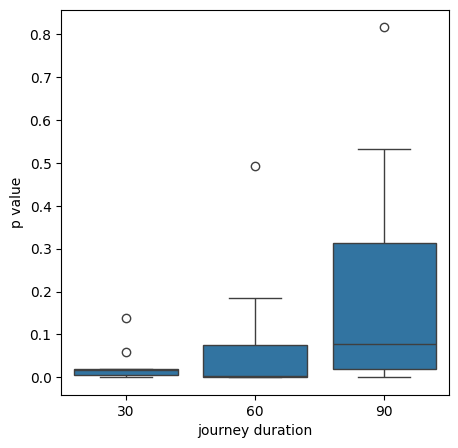

In [55]:
from matplotlib import pyplot as plt
import seaborn as sns


f, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.boxplot(data=plotDf, x='journey duration', y='p value')

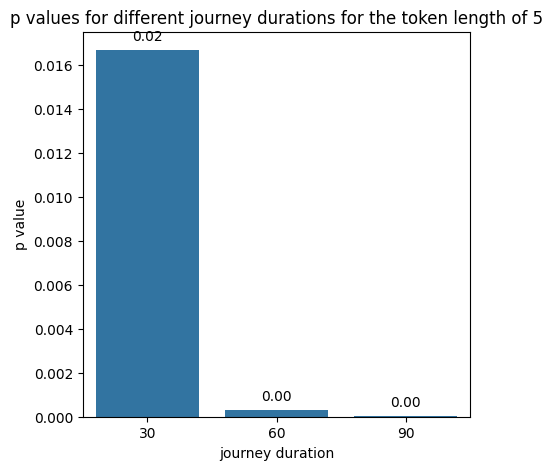

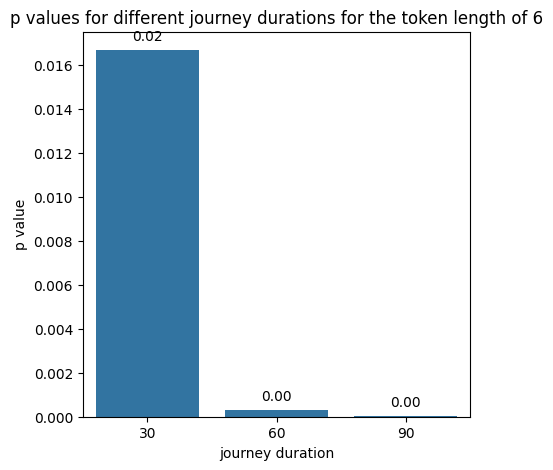

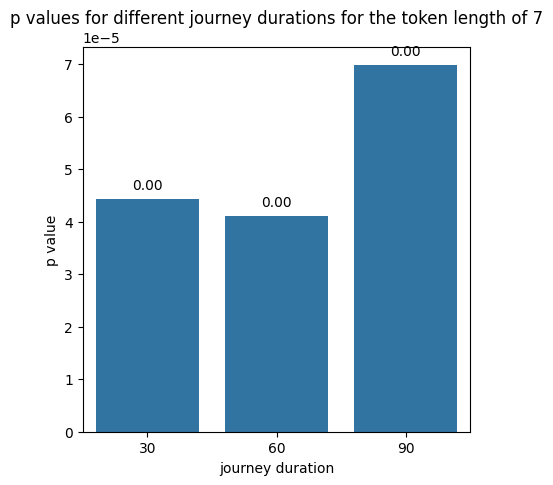

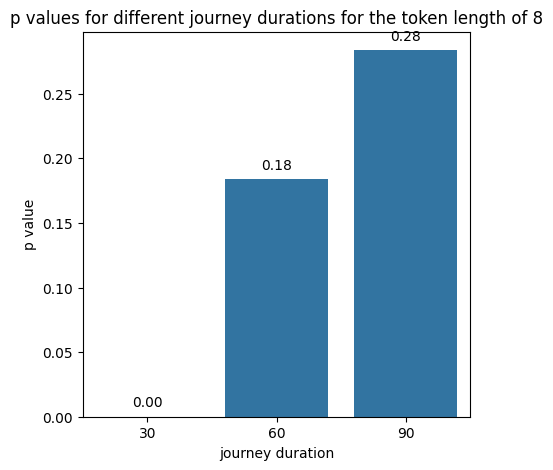

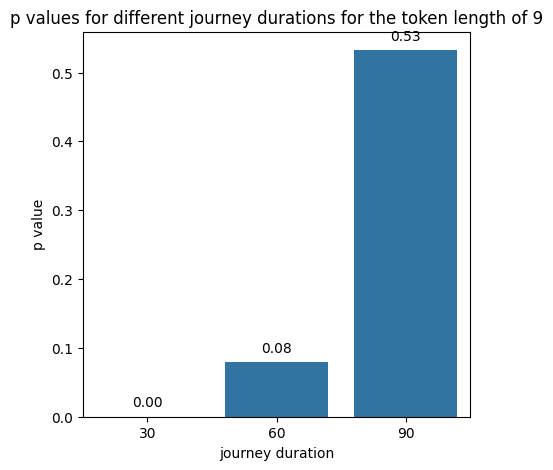

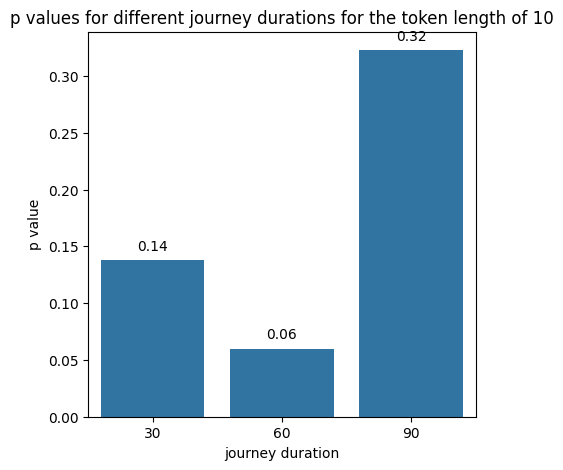

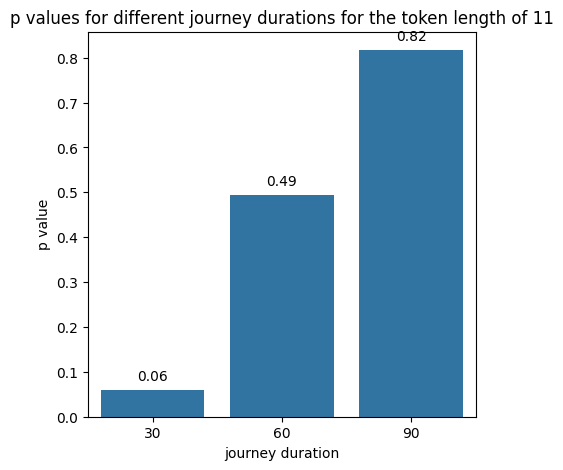

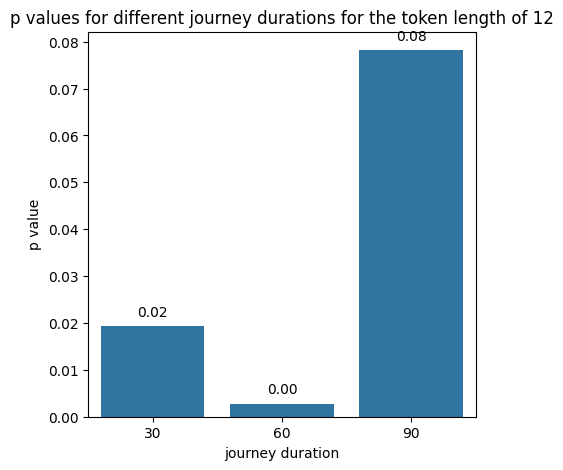

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns


for tokenLength in range(5, 13):
    f, ax = plt.subplots(1, 1, figsize=(5, 5))

    sns.barplot(plotDf[plotDf['token length'] == tokenLength], x='journey duration', y='p value',  ax=ax)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    ax.set_title('p values for different journey durations for the token length of ' + str(tokenLength))

    plt.show()

### For different journey durations

<Axes: xlabel='token length', ylabel='p value'>

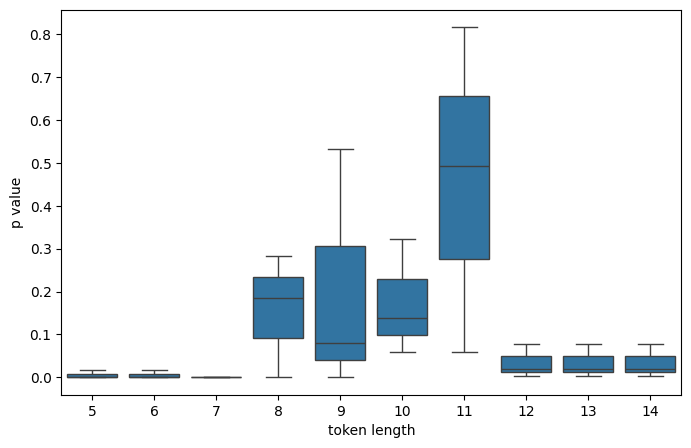

In [57]:
from matplotlib import pyplot as plt
import seaborn as sns


f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.boxplot(data=plotDf, x='token length', y='p value')

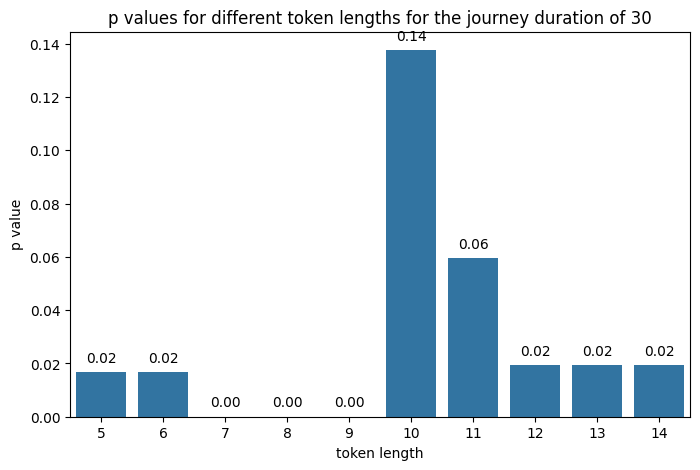

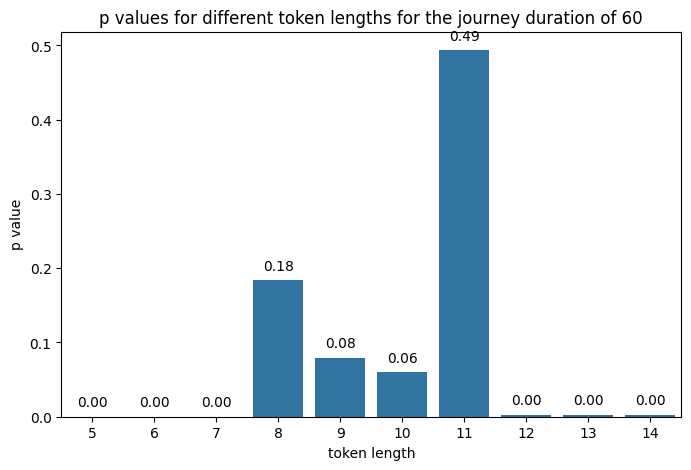

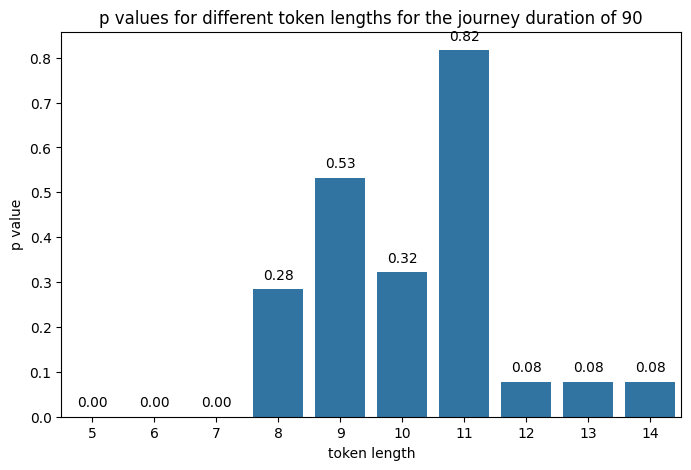

In [58]:
from matplotlib import pyplot as plt
import seaborn as sns


for duration in range(30, 120, 30):
    f, ax = plt.subplots(1, 1, figsize=(8, 5))

    sns.barplot(plotDf[plotDf['journey duration'] == duration], x='token length', y='p value',  ax=ax)

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    ax.set_title('p values for different token lengths for the journey duration of ' + str(duration))

    plt.show()

### Combined heatmap

In [59]:
heatmapDf = plotDf.pivot_table(index='token length',columns='journey duration', values='p value', aggfunc='mean')
heatmapDf

journey duration,30,60,90
token length,,,
5,1.668526e-02,0.000297,0.000023
6,1.668526e-02,0.000297,0.000023
7,4.431000e-05,0.000041,0.000070
8,4.431000e-05,0.183831,0.283768
9,8.583746e-10,0.079478,0.532664
10,1.375849e-01,0.059912,0.322794
11,5.956082e-02,0.493741,0.816858
12,1.935694e-02,0.002771,0.078216
13,1.935694e-02,0.002771,0.078216


[Text(0.5, 25.722222222222214, 'Duration'),
 Text(33.22222222222222, 0.5, 'Minimum token length')]

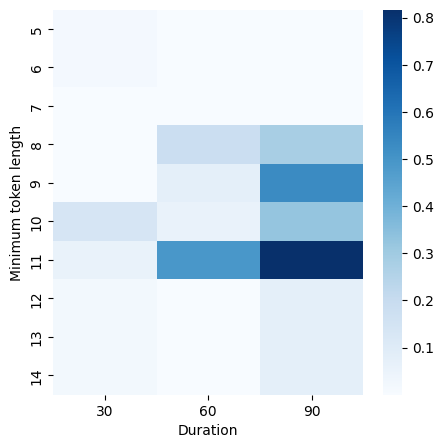

In [60]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax = sns.heatmap(
    heatmapDf,
    # annot=True,
    # fmt=".2f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Minimum token length')

[Text(0.5, 25.722222222222214, 'Duration'),
 Text(33.22222222222222, 0.5, 'Minimum token length')]

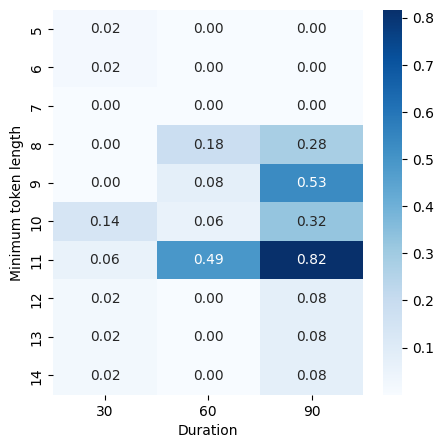

In [61]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax = sns.heatmap(
    heatmapDf,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Minimum token length')

In [62]:
plotDf['significant'] = plotDf['p value'] > 0.05
heatmapDf = plotDf.pivot_table(index='token length',columns='journey duration', values='significant')
heatmapDf

journey duration,30,60,90
token length,,,
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,1.0,1.0
9,0.0,1.0,1.0
10,1.0,1.0,1.0
11,1.0,1.0,1.0
12,0.0,0.0,1.0
13,0.0,0.0,1.0


[Text(0.5, 25.722222222222214, 'Duration'),
 Text(33.22222222222222, 0.5, 'Significant')]

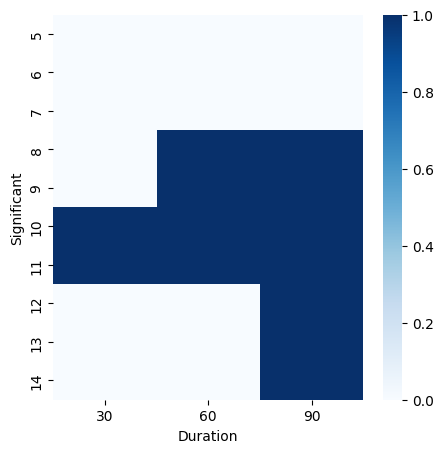

In [63]:
import seaborn as sns

f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax = sns.heatmap(
    heatmapDf,
    # annot=True,
    # fmt=".1f",
    cmap="Blues",
    # vmin=0.6,
    # vmax=0.9,
    # yticklabels=['0', '1', '2'],
    # xticklabels=['1', '2', '3', '4', '5', '6'],
    
)
ax.set(xlabel='Duration', ylabel='Significant')